### 一. Original Hard-marginal SVM

+ 动机：找一条胖胖的分割线，使得算法的VC维低，即所得模型的通用性高，不容易过拟合（相对于PLA）

+ 抽象为最优化问题，并将公式一步步转化为容易解决的二次规划问题

$$\max\limits_{w,b} fatness(w, b)$$
$$s.t.$$
$$y_n (w^T x_n + b) \geq 0$$
$$fatness(w, b) = \min\limits_{0 \leq n < N} distance(x_n, w, b) $$

$$\Downarrow margin \leftarrow fatness, 展开distance, 且意识到y_n (w^T x_n + b) =|w^T x_n + b|$$

$$\max \limits_{w,b} margin(w, b)$$
$$s.t.$$
$$margin(w, b) = \min\limits_{0 \leq n < N} \frac{1}{||w||} y_n (w^T x_n + b) $$

$$\Downarrow 利用平面的放缩不变性，使得margin(w,b) = \frac{1}{||w||} $$

$$\max \limits_{w,b} \frac{1}{||w||} $$
$$s.t.$$
$$\min\limits_{0 \leq n < N}  y_n (w^T x_n + b) = 1$$

$$\Downarrow 放松限制条件，将最大化变最小化，点积代替取模运算 $$

$$\min \limits_{w,b} \frac{1}{2} w^T w $$
$$s.t.$$
$$y_n (w^T x_n + b) \geq 1$$

    上述放松限制条件的操作之所以有效，可以用反证法证明在放松的限制条件下得到的w和b和原问题一致．上述问题可以直接丢到现成的二次规划算法里面求解．上述分类平面是线性的，若要实现非线性的效果，可以对原始特征进行转化（到高维空间）．下面就用解二次规划的方法来实现SVM，其中所用Solver来自CVXOPT包：

$$ \min \frac{1}{2}u^T Q u + p^T u $$
$$ s.t. $$
$$ G u \leq h $$
$$ A u = b $$

$$ u = \left[ \begin{array}{c} b \\ w \\ \end{array} \right], Q = \left[ \begin{array}{cc} 0 & 0_{1*d} \\ 0_{d*1} & I_{d*d} \end{array} \right], p = 0_{(d+1)*1}, G_{n*(d+1)} = \left[ \begin{array}{c} . \\ . \\ -y_n [1, x_n^T] \\ \end{array} \right], h = -1_{n}$$

$$ cvxopt.solvers.qp(Q, p, [, G, h [, A, b]]) $$

In [24]:
# 导入iris数据集
from sklearn import datasets
import numpy as np
from cvxopt import matrix, solvers

iris = datasets.load_iris()
iris = zip(iris.data, iris.target)
iris_01 = filter(lambda (X, y): y == 0 or y == 1, iris)
X = np.array(map(lambda (X, y): X, iris_01))[:, 0:2]
Y = np.array(map(lambda (X, y): 1 if y == 0 else -1, iris_01))
Y.shape = (len(X), 1)

In [26]:
%%time

#调用QP程序得到分类面(w, b)
d = X.shape[1]
n = X.shape[0]
Q = np.eye(d + 1)
Q[0][0] = 0
p = np.zeros((d + 1, 1))
G = np.hstack((np.ones((n, 1)), X)) * -Y
h = - np.ones((n, 1))

Q = matrix(Q)
p = matrix(p)
G = matrix(G)
h = matrix(h)

sol = solvers.qp(Q, p, G, h)

b = sol['x'][0]
w = sol['x'][1:]
print '-' * 100
print 'b:'
print b
print 'w:'
print w

     pcost       dcost       gap    pres   dres
 0:  1.1014e+00  5.0091e+01  3e+02  2e+00  1e+02
 1:  7.5918e+00 -4.5992e+01  1e+02  8e-01  4e+01
 2:  1.6944e+01 -4.1454e+01  1e+02  5e-01  2e+01
 3:  3.1275e+01 -2.6478e+00  5e+01  2e-01  7e+00
 4:  3.3601e+01  3.0481e+01  4e+00  1e-02  5e-01
 5:  3.3793e+01  3.3757e+01  4e-02  1e-04  6e-03
 6:  3.3795e+01  3.3795e+01  4e-04  1e-06  6e-05
 7:  3.3795e+01  3.3795e+01  4e-06  1e-08  6e-07
 8:  3.3795e+01  3.3795e+01  4e-08  1e-10  6e-09
Optimal solution found.
----------------------------------------------------------------------------------------------------
b:
17.3157894733
w:
[-6.32e+00]
[ 5.26e+00]

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.73 ms


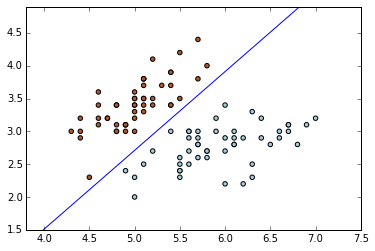

In [28]:
%matplotlib inline
#画出分类面，由于用目前可用的得到支持向量的方法比较丑陋，所以暂时先不形象的画出分类面的胖度，留到下一节．
import matplotlib.pyplot as plt

plt.figure()

x0_min, x0_max = min(X[:, 0]) - 0.5, max(X[:, 0]) + 0.5
x1_min, x1_max = min(X[:, 1]) - 0.5, max(X[:, 1]) + 0.5

plt.xlim(x0_min, x0_max)
plt.ylim(x1_min, x1_max)
plt.scatter(X[:, 0], X[:, 1] , c=Y, cmap=plt.cm.Paired)

line_x = np.linspace(int(x0_min), int(x0_max))
line_y = map(lambda x0: (-b - w[0] * x0) / w[1], line_x)

plt.plot(line_x, line_y)

plt.show()


二. Dual Hard-marginal SVM

+ 动机：原始二次规划问题的复杂度跟特征的维度有关系，即效率受限于特征的维度．想办法去除这一限制，以便可以对特征进行任意扩充，甚至可以扩充到无限维．